# 1. Install Dependencies and Setup

In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.2.0
certifi                      2022.12.7
charset-normalizer           2.1.1
colorama                     0.4.6
contourpy                    1.0.6
cycler                       0.11.0
debugpy                      1.6.4
decorator                    5.1.1
entrypoints                  0.4
executing                    1.2.0
flatbuffers                  22.12.6
fonttools                    4.38.0
gast                         0.4.0
google-auth                  2.15.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.51.1
h5py                         3.7.0
idna                         3.4
ipykernel                    6.17.1
ipython                      8.7.0
jedi                         0.18.2
jupyte

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

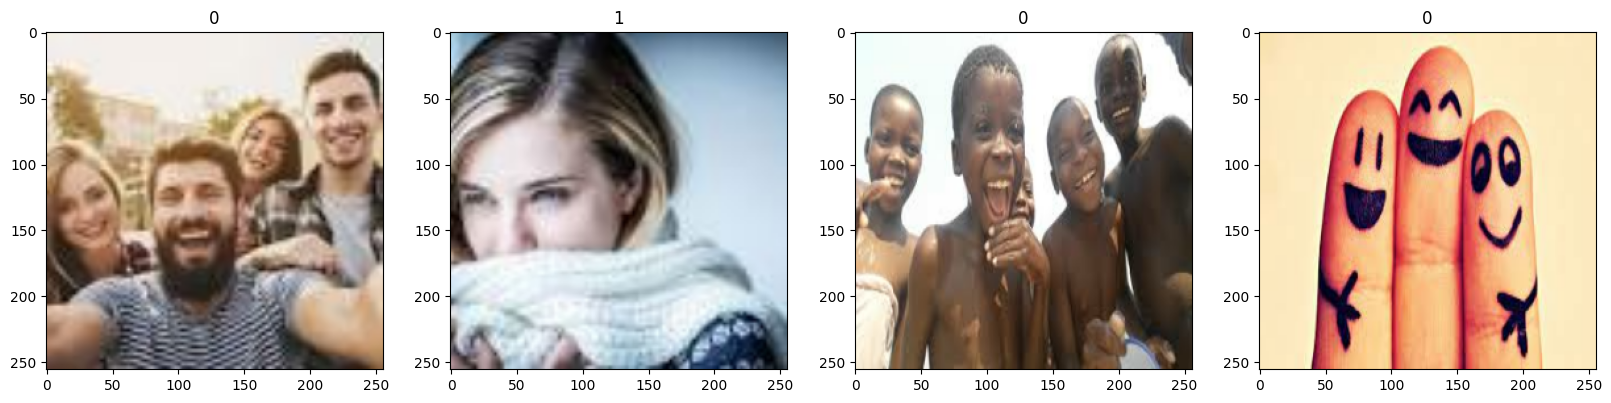

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
data.as_numpy_iterator().next()

(array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

# 5. Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train_size

7

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 13s 1s/step - loss: 1.0659 - accuracy: 0.4643 - val_loss: 0.6684 - val_accuracy: 0.6094
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.6566 - accuracy: 0.5402 - val_loss: 0.6161 - val_accuracy: 0.6250
Epoch 3/20
7/7 [==============================] - 11s 1s/step - loss: 0.5514 - accuracy: 0.7634 - val_loss: 0.4861 - val_accuracy: 0.7969
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.6783 - accuracy: 0.6786 - val_loss: 0.4858 - val_accuracy: 0.9219
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.5539 - accuracy: 0.7455 - val_loss: 0.6049 - val_accuracy: 0.6562
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.5536 - accuracy: 0.7946 - val_loss: 0.5092 - val_accuracy: 0.7500
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.5404 - accuracy: 0.7232 - val_loss: 0.4488 - val_accuracy: 0.8281
Epoch 8/20
7/7 [==================

# 8. Plot Performance

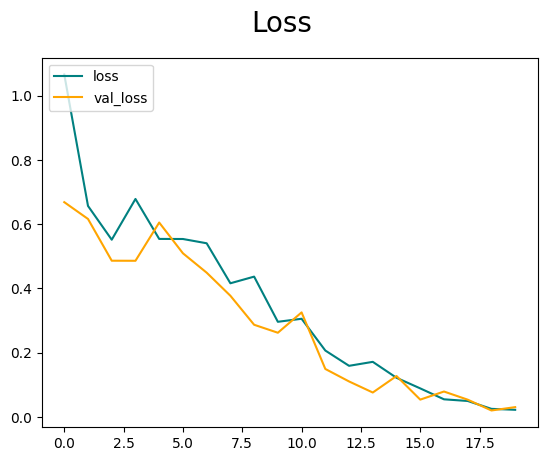

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

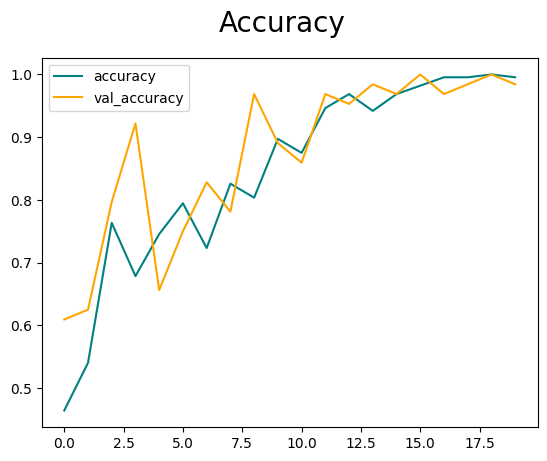

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 255ms/step


In [33]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [34]:
import cv2

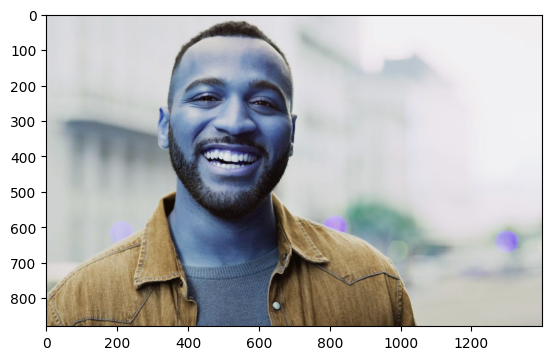

In [74]:
img = cv2.imread('happy1.jpg')
plt.imshow(img)
plt.show()

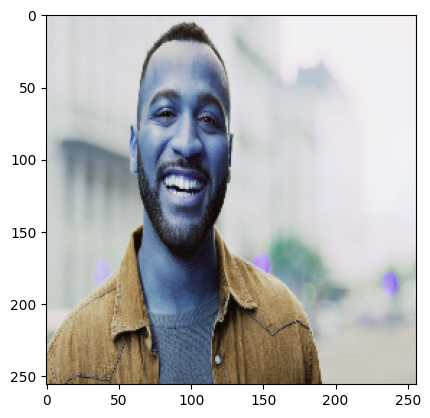

In [75]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [76]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 45ms/step


In [77]:
yhat

array([[0.00905445]], dtype=float32)

In [78]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('models','imageclassifier.h5'))

In [54]:
new_model = load_model('models/imageclassifier.h5')

In [55]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 102ms/step


array([[0.94871473]], dtype=float32)